##### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

##### Exploring the data

In [2]:
import pathlib
data_dir = "hpa-single-cell-image-classification/train/"
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = os.listdir(data_dir)
len(image_count)

87224

In [4]:
df_train = pd.read_csv("hpa-single-cell-image-classification/train.csv")

In [5]:
df_train.head()

ID  Label
0  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0  8|5|0
1  5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0   14|0
2  60b57878-bb99-11e8-b2b9-ac1f6b6435d0    6|1
3  5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0  16|10
4  5b931256-bb99-11e8-b2b9-ac1f6b6435d0   14|0

In [6]:
len(df_train)

21806

In [7]:
df_samp_sub = pd.read_csv("hpa-single-cell-image-classification/sample_submission.csv")

In [8]:
df_samp_sub.head()

ID  ImageWidth  ImageHeight  \
0  0040581b-f1f2-4fbe-b043-b6bfea5404bb        2048         2048   
1  004a270d-34a2-4d60-bbe4-365fca868193        2048         2048   
2  00537262-883c-4b37-a3a1-a4931b6faea5        2048         2048   
3  00c9a1c9-2f06-476f-8b0d-6d01032874a2        2048         2048   
4  0173029a-161d-40ef-af28-2342915b22fb        3072         3072   

           PredictionString  
0  0 1 eNoLCAgIMAEABJkBdQ==  
1  0 1 eNoLCAgIMAEABJkBdQ==  
2  0 1 eNoLCAgIMAEABJkBdQ==  
3  0 1 eNoLCAgIMAEABJkBdQ==  
4  0 1 eNoLCAgIsAQABJ4Beg==

In [9]:
train_images = "hpa-single-cell-image-classification/train/"
train_images = os.listdir(train_images)
#train_images

### Note
*  the following code below shows that there are 4 images in the train folder assoicated with the image ID that corresponds to Red, Blue, Green, and Yellow channels...In other words, 4 images per ID that are differentiated by color (Red, Blue, Green, Yellow)

In [10]:
len(df_train), len(train_images), len(train_images)/len(df_train)

(21806, 87224, 4.0)

##### Plot of the number of labels

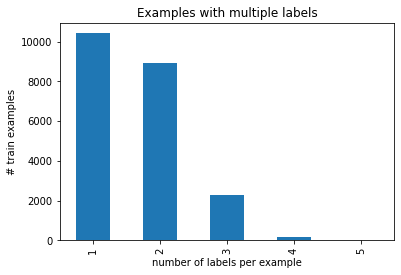

In [11]:
df_train['num_classes'] = df_train['Label'].apply(lambda r: len(r.split('|')))
df_train['num_classes'].value_counts().plot.bar(title='Examples with multiple labels', xlabel='number of labels per example', ylabel='# train examples')
plt.show()

##### Things to keep in mind regarding channels
* Red (Microtubules)
* Green (Protein of interest)
* Blue (Nucleus)
* Yellow (Endoplasmic reticulum)

#### Here we seperate the images based on the ID and color

In [12]:
path = "hpa-single-cell-image-classification"
mt = [path+'/train/'+(id+'_red.png') for id in df_train.ID.values]
er = [path+'/train/'+(id+'_yellow.png') for id in df_train.ID.values]
nu = [path+'/train/'+(id+'_blue.png') for id in df_train.ID.values]
pr = [path+'/train/'+(id+'_green.png') for id in df_train.ID.values]
images = [mt, er, nu, pr]
titles = ['microtubules', 'endoplasmic reticulum', 'nucleus', 'protein of interest']

#### Images of each channel of their own

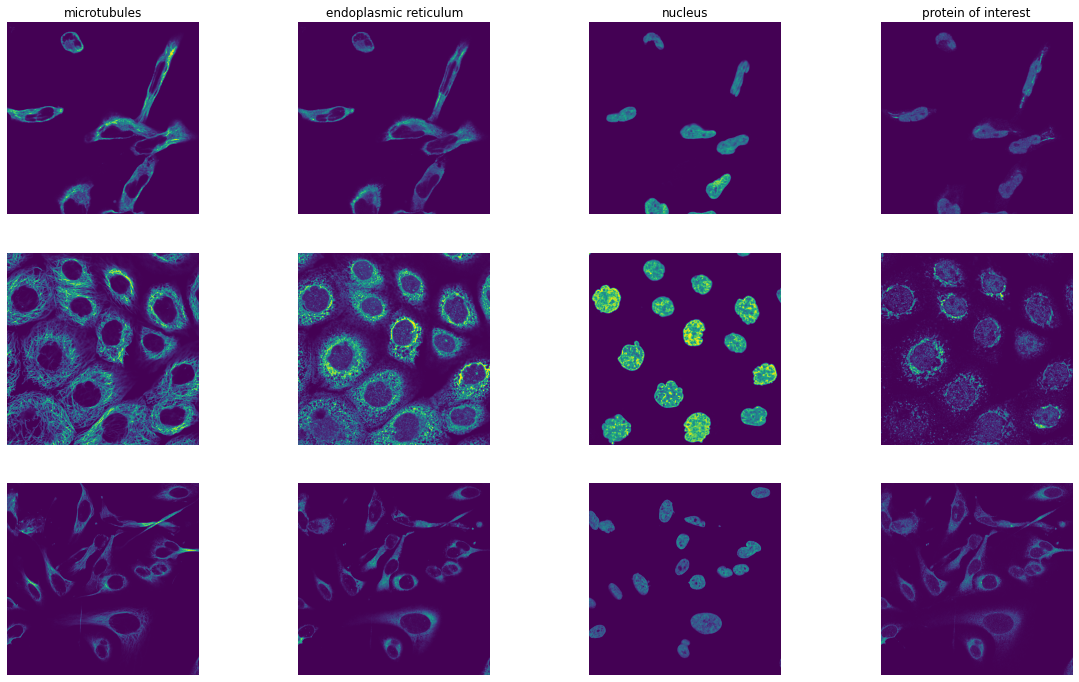

In [13]:
fig, ax = plt.subplots(3,4, figsize=(20,12))
for j in range(3):
    for i in range(4):
        img = plt.imread(images[i][j])
        if j == 0: ax[j,i].set_title(titles[i])
        ax[j,i].imshow(img)
        ax[j,i].axis('off')
plt.show()

##### Images combining the channels stacked together (Red,Blue,Yellow)

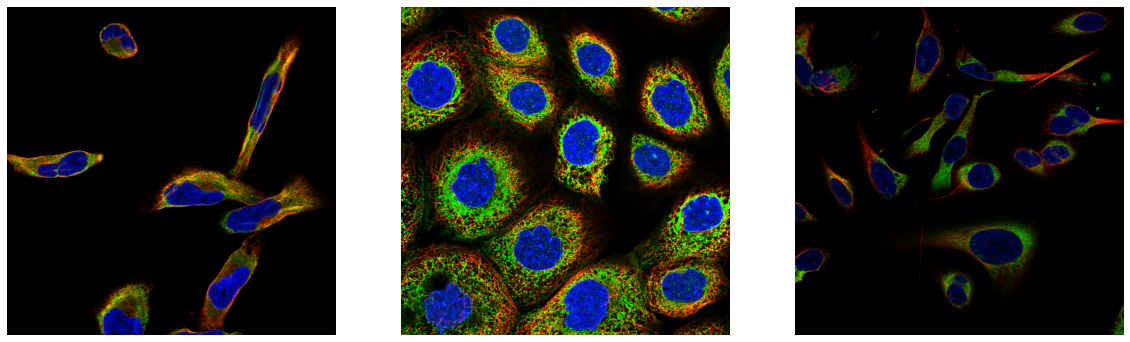

In [14]:
fig, ax = plt.subplots(1,3, figsize=(20,50))
for i in range(3):
    microtubule = plt.imread(mt[i])    
    endoplasmicrec = plt.imread(er[i])    
    nuclei = plt.imread(nu[i])
    img = np.dstack((microtubule, endoplasmicrec, nuclei))
    ax[i].imshow(img)
    ax[i].axis('off')
plt.show()

##### Images combining the channels stacked together (Red,Green,Blue)

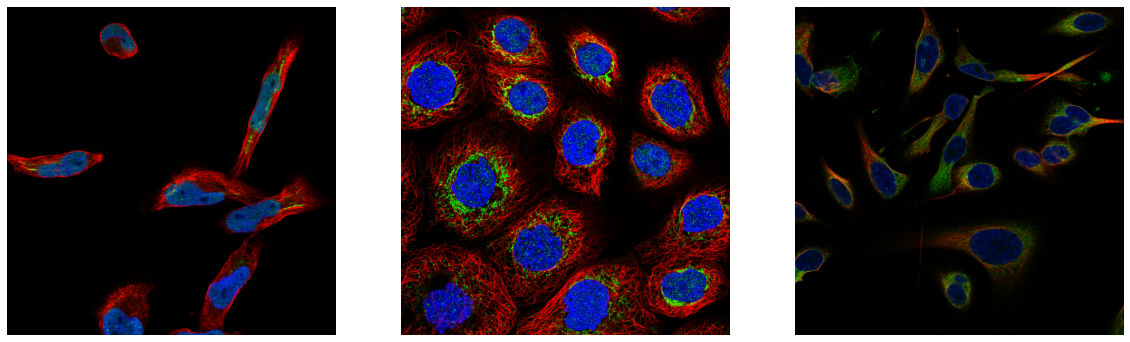

In [15]:
fig, ax = plt.subplots(1,3, figsize=(20,50))
for i in range(3):
    microtubule = plt.imread(mt[i])    
    protein = plt.imread(pr[i])    
    nuclei = plt.imread(nu[i])
    img = np.dstack((microtubule, protein, nuclei))
    ax[i].imshow(img)
    ax[i].axis('off')
plt.show() 

##### Images combining the channels stacked together (Red,Green,Yellow)

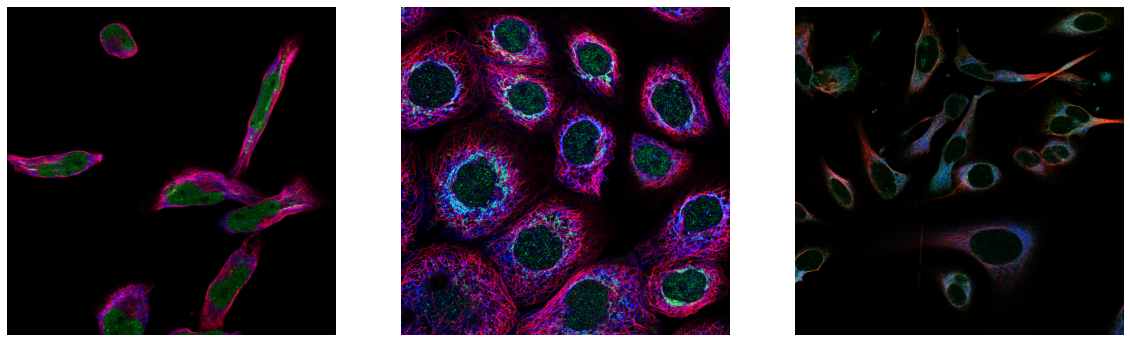

In [16]:
fig, ax = plt.subplots(1,3, figsize=(20,50))
for i in range(3):
    microtubule = plt.imread(mt[i])    
    protein = plt.imread(pr[i])    
    nuclei = plt.imread(nu[i])
    endoplasmicrec = plt.imread(er[i])
    img = np.dstack((microtubule, protein,endoplasmicrec))
    ax[i].imshow(img)
    ax[i].axis('off')
plt.show() 

##### Images combining the channels stacked together (Blue,Green,Yellow)

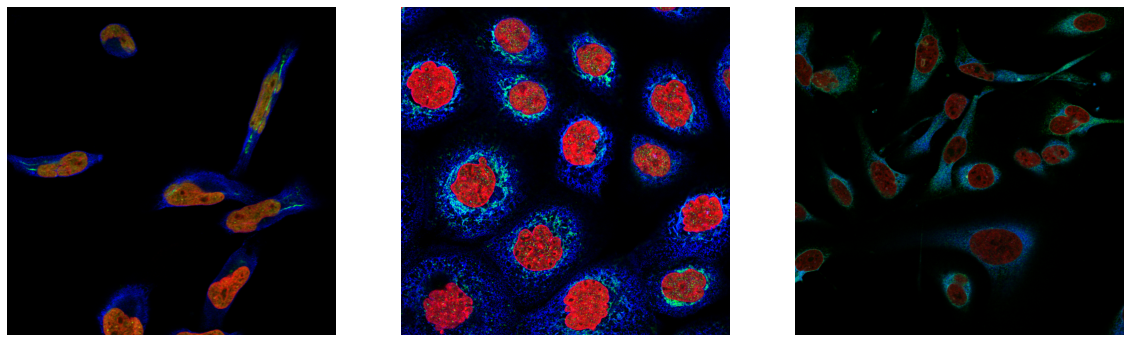

In [17]:
fig, ax = plt.subplots(1,3, figsize=(20,50))
for i in range(3):
    microtubule = plt.imread(mt[i])    
    protein = plt.imread(pr[i])    
    nuclei = plt.imread(nu[i])
    endoplasmicrec = plt.imread(er[i])
    img = np.dstack((nuclei, protein,endoplasmicrec))
    ax[i].imshow(img)
    ax[i].axis('off')
plt.show() 

In [18]:
import imageio
from PIL import Image

##### Generating stacked Images

In [21]:
labels = [str(i) for i in range(19)]
class_images = []
for label in labels:
    r_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_red.png'
    y_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_yellow.png'
    b_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_blue.png'
    r = imageio.imread(path+'/train/'+r_img)
    y = imageio.imread(path+'/train/'+y_img)
    b = imageio.imread(path+'/train/'+b_img)
#     print(r.shape)
#     print(y.shape)
#     print(b.shape)
    rgb = np.dstack((r,y,b))
#    print(type(rgb))
    class_images.append(PIL.Image.frombytes('RGB',r.shape,rgb))

codes = [
'0. Nucleoplasm',
'1. Nuclear membrane',
'2. Nucleoli',
'3. Nucleoli fibrillar center',
'4. Nuclear speckles',
'5. Nuclear bodies',
'6. Endoplasmic reticulum',
'7. Golgi apparatus',
'8. Intermediate filaments',
'9. Actin filaments',
'10. Microtubules',
'11. Mitotic spindle',
'12. Centrosome',
'13. Plasma membrane',
'14. Mitochondria',
'15. Aggresome',
'16. Cytosol',
'17. Vesicles and punctate cytosolic patterns',
'18. Negative'
]


##### Images after stacks the RGB images


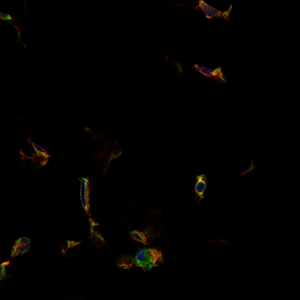
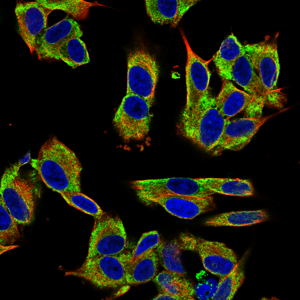
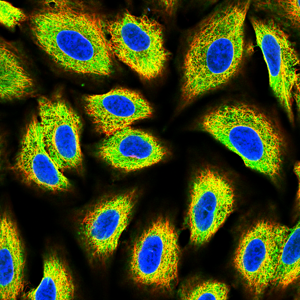
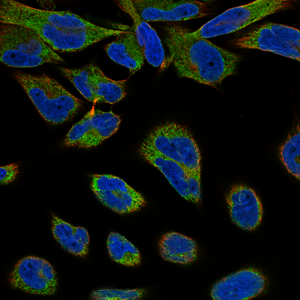
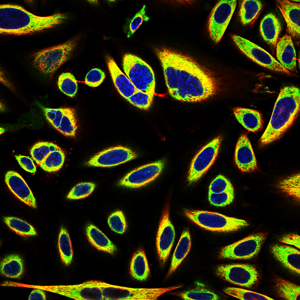
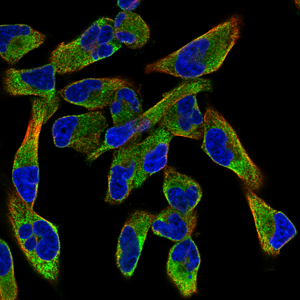
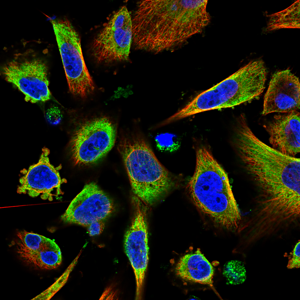
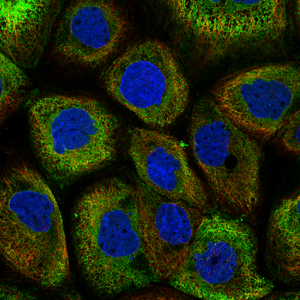
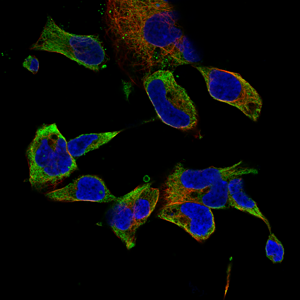
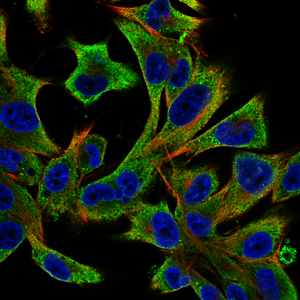
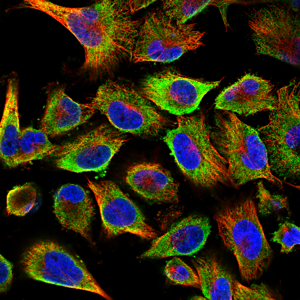
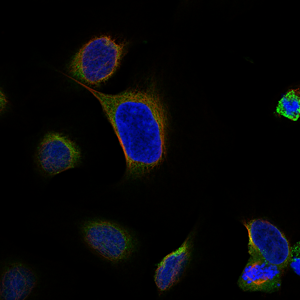
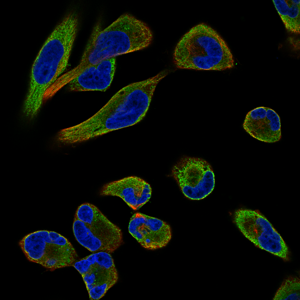
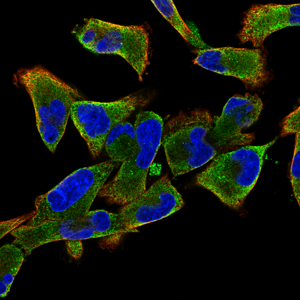
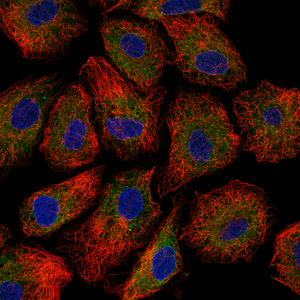
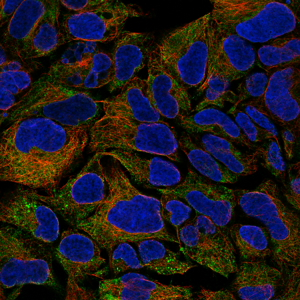
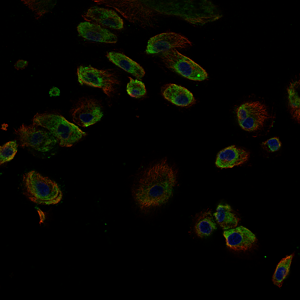
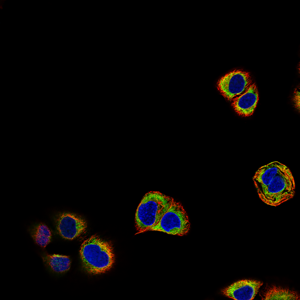
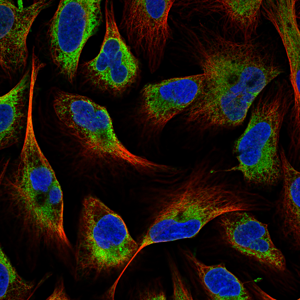


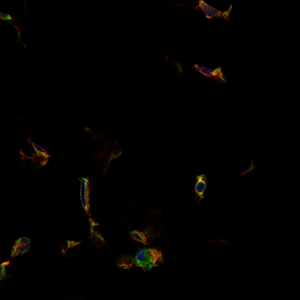
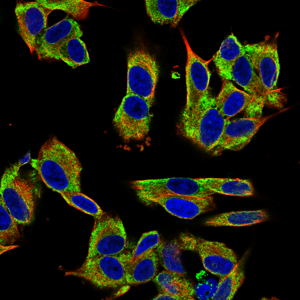
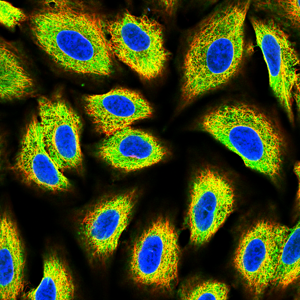
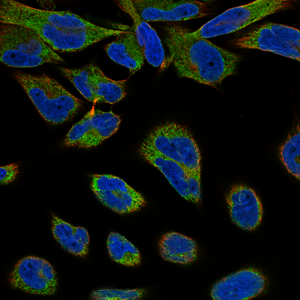
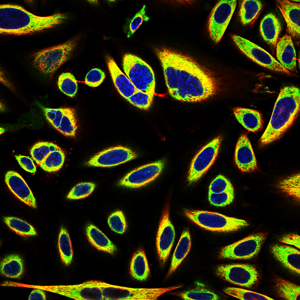
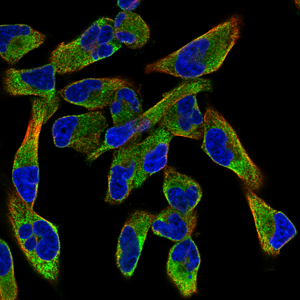
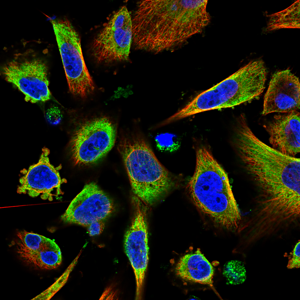
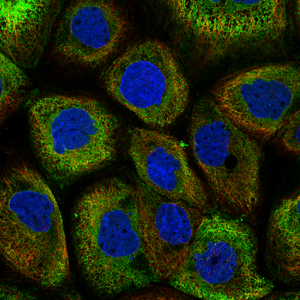
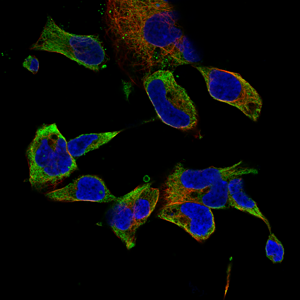
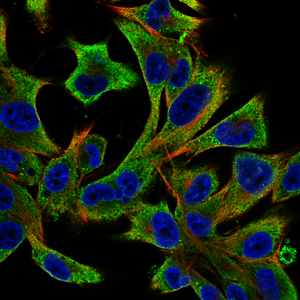
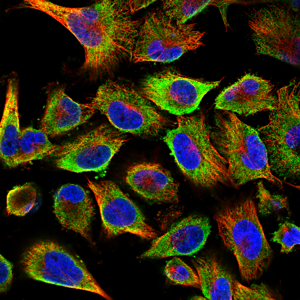
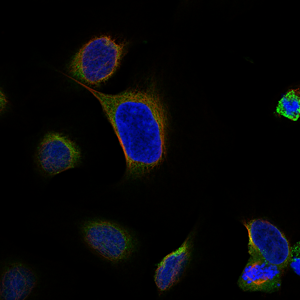
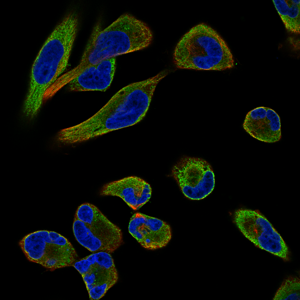
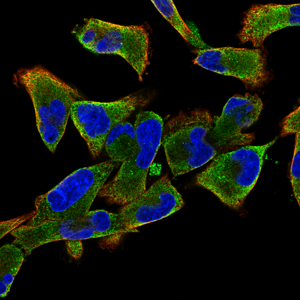
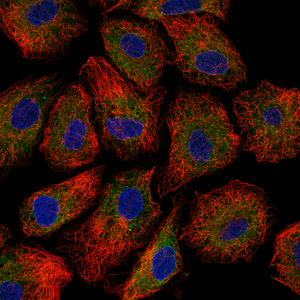
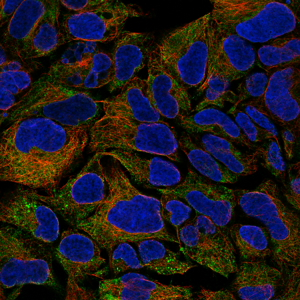
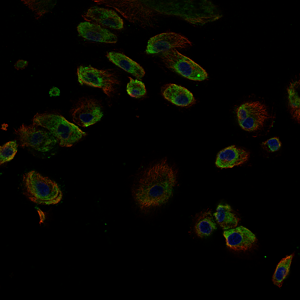
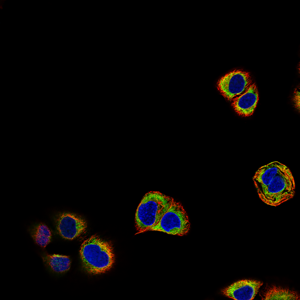
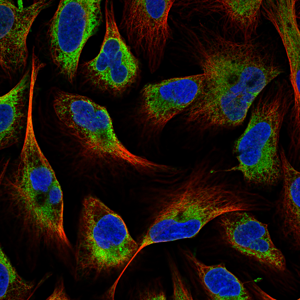

In [22]:
import ipyplot
ipyplot.plot_images(images=class_images, labels=codes, max_images=19, img_width=300)

In [23]:
len(class_images)

19

In [24]:
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei
import glob

mt = glob.glob(path + '/train/' + '*_red.png')
er = [f.replace('red', 'yellow') for f in mt]
nu = [f.replace('red', 'blue') for f in mt]
images = [mt, er, nu]


NUC_MODEL = "./nuclei-model.pth"
CELL_MODEL = "./cell-model.pth"
segmentator = cellsegmentator.CellSegmentator(
    NUC_MODEL,
    CELL_MODEL,
    scale_factor=0.25,
    device="cuda",
    padding=False,
    multi_channel_model=True,
)

# For nuclei
nuc_segmentations = segmentator.pred_nuclei(images[2])

# For full cells
cell_segmentations = segmentator.pred_cells(images)

# post-processing
for i, pred in enumerate(cell_segmentations):
    nuclei_mask, cell_mask = label_cell(nuc_segmentations[i], cell_segmentations[i])
    FOVname = os.path.basename(mt[i]).replace('red','predictedmask')
    imageio.imwrite(os.path.join(save_dir,FOVname), cell_mask) 

No GPU found, using CPU.


please compile abn


C:\Users\micha\anaconda3\envs\tensor\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'pytorch_zoo.unet.DPNUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\micha\anaconda3\envs\tensor\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\micha\anaconda3\envs\tensor\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code b

KeyboardInterrupt: 

FileNotFoundError: [Errno 2] No such file or directory: 'hpa-single-cell-image-classification/train\\000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_predictedmask.png'

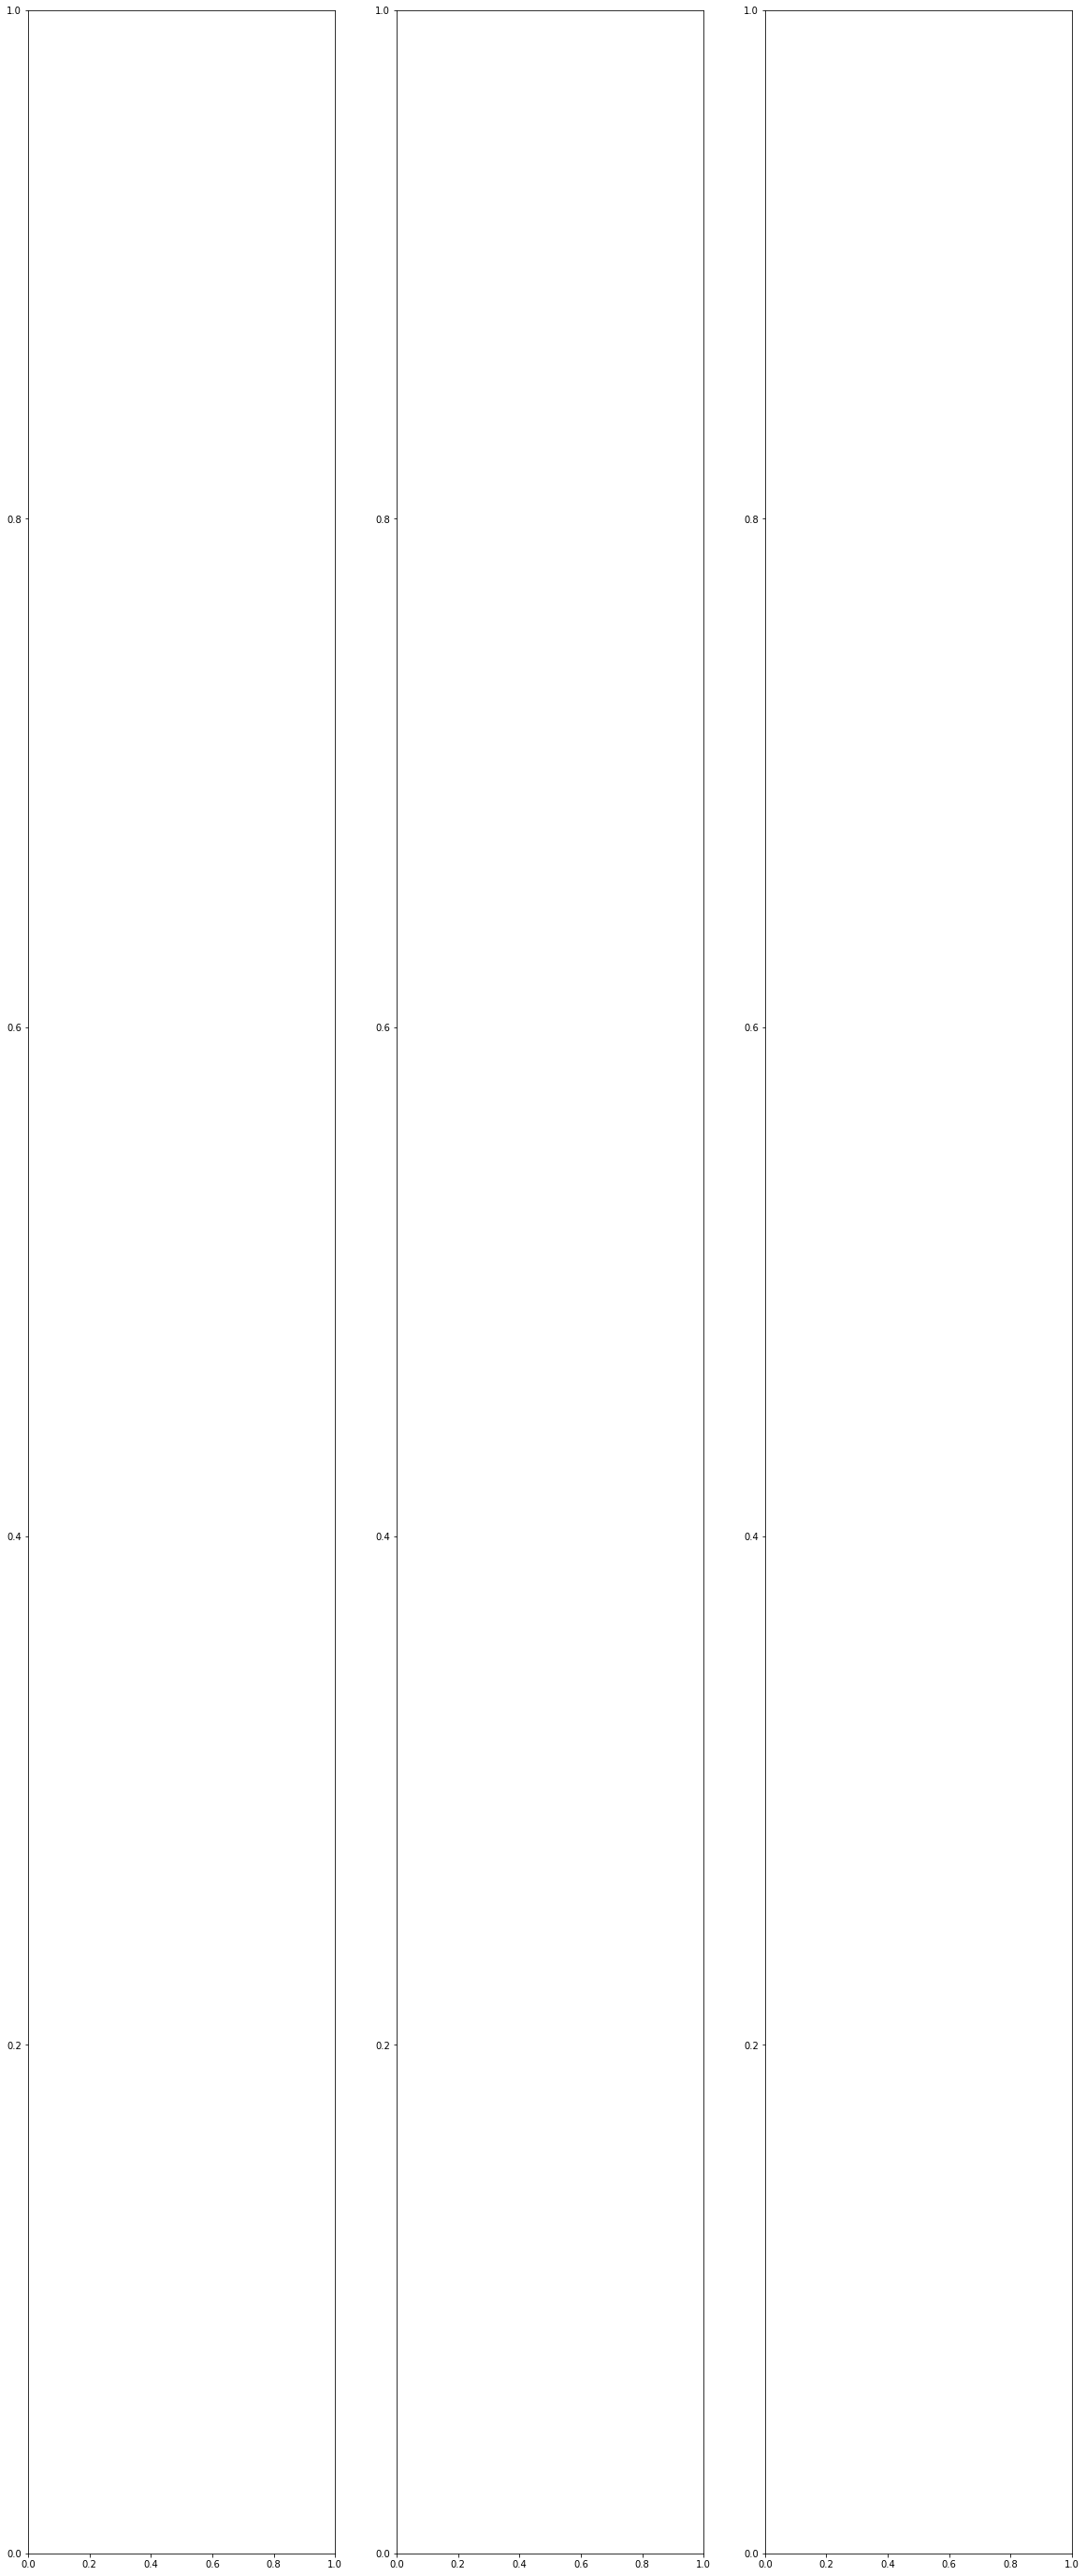

In [25]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(20,50))
for i in range(3):
    microtubule = plt.imread(mt[i])    
    endoplasmicrec = plt.imread(er[i])    
    nuclei = plt.imread(nu[i])
    mask = plt.imread(mt[i].replace('red','predictedmask'))
    img = np.dstack((microtubule, endoplasmicrec, nuclei))
    ax[i].imshow(img)
    ax[i].imshow(mask, alpha=0.5)
    ax[i].axis('off')
plt.show()